In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from celluloid import Camera
import networkx as nx

import tensorflow as tf
from tensorflow import keras

# %matplotlib notebook

In [14]:
class Distributed_System():
    # ---------------------------------------------------------------------------------------
    def __init__(self, N, L):
        np.random.seed(44)
        self.N = N
        self.L = L
        
        # Variables: x , y (positions of agents in plan)
        self.x = np.random.rand(N)*L           # Initialize xᵢ
        self.y = np.random.rand(N)*L           # Initialize yᵢ
        
#         delta = L/(N**0.5)
#         for i in range(N):
#             self.x[i] = 0.5+ int(i/ round(N**0.5)) *delta + np.random.rand()*0.2*delta
#             self.y[i] = 0.5+ int(i% round(N**0.5)) *delta + np.random.rand()*0.2*delta
        
        
        self.r = np.ones(N)                    # Wave sending radius
        self.A = np.zeros((N,N))               # Adjacency Matrix
        self.k = np.zeros(N)                   # Degree of a vertex
        for i in range(N):
            for j in range(i+1,N):
                distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                if distance <= self.r[i] and distance <= self.r[j]:
                    self.A[i][j] = self.A[j][i] = 1
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]
          
    # ---------------------------------------------------------------------------------------    
    def step(self, action, epsilon):

        delta_r = action*(0.16*self.L**2/self.N)*np.random.random(size=self.N)
        reward = self.calc_rewards(delta_r)
        self.r += delta_r
        # if epsilon < 0.75:
        #     self.check(delta_r, reward)
        
        self.A  = np.zeros((self.N,self.N))
        self.k  = np.zeros(self.N)
        rho     = np.zeros(self.N)
        
        for i in range(self.N):
            
            if self.r[i] < 0:     self.r[i] = 0
            if self.r[i] > 2**0.5*self.L: self.r[i] = 2**0.5*self.L

            for j in range(i+1, self.N):
                distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                if distance <= self.r[i] and distance <= self.r[j]:
                    self.A[i][j] = self.A[j][i] = 1
                    self.k[i]   += self.A[i][j]
                    self.k[j]   += self.A[i][j]
                
                if distance <= 1.6: 
                    rho[i] += 1
                    rho[j] += 1

        return ([ self.k+1, self.r+1, rho+1 ], -reward)

    # ---------------------------------------------------------------------------------------    
    def check(self, delta_r, delta_H):
        for i in range(self.N):
            if (delta_H[i] > 0)  and  (np.random.random() < np.exp(delta_H[i]/4)) :
                self.r[i] -= delta_r[i]*np.random.random()

    # ---------------------------------------------------------------------------------------    
    def calc_rewards(self, delta_r):
        
        Hamilton_t0 = self.Hamiltonian()[0]    ###

        self.A  = np.zeros((self.N,self.N))
        self.k  = np.zeros(self.N)

        reward  = np.zeros(self.N) 
        radius  = np.copy(self.r)

        for i in range(self.N):

            self.r = np.copy(radius)
            self.r[i] += delta_r[i]
            if self.r[i] < 0:     self.r[i] = 0
            if self.r[i] > 2**0.5*self.L: self.r[i] = 2**0.5*self.L

            for j in range(self.N):
                if i != j:
                    distance = ( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5
                    if distance <= self.r[i] and distance <= self.r[j]:
                        self.A[i][j] = 1
                        self.k[i]   += self.A[i][j]

            Hamilton_t1 = self.Hamiltonian()[0]    ###
            reward[i] = Hamilton_t1[i] - Hamilton_t0[i]
        
        return reward

    # ---------------------------------------------------------------------------------------    
    def Hamiltonian(self):
        alfa_1 = -0.5
        alfa_2 = +0.1
        alfa_3 = +0.2
        alfa_4 = -0.5
        
        fourth = np.zeros(self.N)
        H      = np.zeros(self.N)
        for i in range(self.N):
            for j in range(i+1, self.N):
                fourth[i] += (self.A[i][j] / (( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 ))
                fourth[j] += (self.A[j][i] / (( (self.x[i]-self.x[j])**2 + (self.y[i]-self.y[j])**2 )**0.5 ))
            
            H[i] = alfa_1*self.k[i]**2 + alfa_2*self.k[i]**3 + alfa_3*self.r[i]**2 + alfa_4*fourth[i]

        return H, fourth                ###
    
    # ---------------------------------------------------------------------------------------
    def Plot(self, camera, episode):
        options = { 'node_size': 60, 'width': 0.3 }
        
        G = nx.from_numpy_array(self.A)
        for i in range(self.N):
            G.add_node(i, pos=(self.x[i], self.y[i]))
        pos = nx.get_node_attributes(G,'pos')
        
        nx.draw_networkx(G, pos, with_labels=True, **options)
        giant = len((sorted(nx.connected_components(G), key=len, reverse=True))[0])/self.N * 100
        
        plt.text(self.L-0.15*self.L, self.L+0.3, f'Episode {episode}', fontname='Comic Sans MS', fontsize=12)
        plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        plt.xlim(-0.1, self.L+0.1); plt.ylim(-0.1, self.L+0.1);
        plt.grid(alpha = 0.3)
        camera.snap()
        return giant

In [3]:
def initializer(env, N):
    # ---------------------------------------------------------------------------------------
    # print first line in log file
    
#     f.close()
    f = open("log_C.txt", "w")
    f.write(f"episode \t epsilon \t ")
    for i in range(N): f.write(f"r{i} \t ")
    for i in range(N): f.write(f"k{i} \t ")
    for i in range(N): f.write(f"k{i}**2 \t ")
    for i in range(N): f.write(f"k{i}**3 \t ")
    for i in range(N): f.write(f"r{i}**2 \t ")
    for i in range(N): f.write(f"fourth{i} \t ")
    for i in range(N): f.write(f"H{i} \t ")
    for i in range(N): f.write(f"reward{i} \t ")
    f.write(f"Hamilton \t\t")
    for i in range(N): f.write(f"All Q{i} \t next Q{i} \t Q{i} \t target Q{i} \t LOSS{i} \t")   ### 
    f.write(f"\t")
    for j in range(3): f.write(f"Grads {j} \t bias {j} \t ")       ###
    for j in range(3): f.write(f"Trainable {j} \t bias {j} \t ")   ###
        
    
    # ---------------------------------------------------------------------------------------
    # build models
    tf.keras.backend.clear_session()
    tf.random.set_seed(42)
    np.random.seed(42)

    input_shape = [3]              # == env.observation_space.shape
    n_outputs = 2                  # == env.action_space.n

    model = []                     # make a model for each agent
    for i in range(N):
#         initializer = tf.keras.initializers.GlorotNormal(seed = tf.random.set_seed(42+i)) # HeNormal()
        model.append(tf.keras.models.Sequential([
            keras.layers.Dense(32, activation="elu", input_shape=input_shape),
            keras.layers.Dense(32, activation="elu"),
            keras.layers.Dense(n_outputs, activation=custom_activation)
        ]))
        
    # ---------------------------------------------------------------------------------------
    # initilaze replay_memory & best_weights
    replay_memory = []             # A bag containing 40 recently viewed items (state, action, reward, next_state)
    best_weights  = []             # The best weights that each model will use to make the best decision
    for i in range(N):
        replay_memory.append(deque(maxlen=40))
        best_weights .append(model[i].get_weights())
        
    # ---------------------------------------------------------------------------------------
    # initilaze states and rewards from environment class    
    state, reward = env.step(np.zeros(N), 1)
    state = [[state[j][i] for j in range(input_shape[0])] for i in range(N)]
    
    return f, model, n_outputs, replay_memory, best_weights, state, reward
    
def custom_activation(x):
    # return tf.keras.backend.switch(x >= 0, x**0.5, -(-x)**0.5)
    xx = (tf.keras.backend.softplus(x))**0.5
    return -tf.keras.backend.elu(-xx + 100) + 100

In [4]:
def log_print(f, N, env, episode, epsilon, reward  ,  all_q, next_q, qq, target_q, LOSS, grads, trainable_variables):
    
    f.write(f"\n{episode} \t {epsilon} \t ")
    for i in range(N): f.write(f"{env.r[i]} \t ")
    for i in range(N): f.write(f"{env.k[i]} \t ")
    for i in range(N): f.write(f"{env.k[i]**2} \t ")
    for i in range(N): f.write(f"{env.k[i]**3} \t ")
    for i in range(N): f.write(f"{env.r[i]**2} \t ")
    for i in range(N): f.write(f"{env.Hamiltonian()[1][i]} \t ")
    for i in range(N): f.write(f"{env.Hamiltonian()[0][i]} \t ")
    for i in range(N): f.write(f"{reward[i]} \t ")
    f.write(f"{env.Hamiltonian()[0].sum()} \t\t")
    
    for i in range(N): 
        f.write(f"{all_q[i][0]} \t ")
        f.write(f"{next_q[i][0]} \t ")
        f.write(f"{qq[i][0]} \t ")
        f.write(f"{target_q[i][0]} \t ")
        f.write(f"{LOSS[i]} \t ")
        
    f.write(f"\t")
    np.set_printoptions(linewidth=np.inf)
    for grad in grads: f.write(f"{grad.numpy().ravel()} \t ")
    for variable in trainable_variables: f.write(f"{variable.numpy().ravel()} \t ")
        

In [5]:
def play_one_step(env, N, model, state, n_outputs, replay_memory, epsilon=0.):
    action = np.zeros(N)

    for i in range(N):
        if np.random.rand() < epsilon:
            action[i] = np.random.randint(n_outputs)
        else:
            actionnnn = model[0].predict(np.reshape(state[i], (3)).reshape(1, -1), verbose=0)[0]
            action[i] = np.argmax(actionnnn)
    
    next_state, reward = env.step((action-0.5)*2 , epsilon)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(N)]
    
    for i in range(N):
        replay_memory[i].append((state[i], action[i], reward[i], next_state[i]))
    return next_state, reward

In [6]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-2)
loss_fn   = tf.keras.losses.mean_squared_error

def training_step(i, model, n_outputs, replay_memory, batch_size, discount):
    discount_rate = discount
    
    indices = np.random.randint(len(replay_memory[i]), size=batch_size)   # 32ta random number between[0 - len(replay)]
    batch   = [replay_memory[i][index] for index in indices]              # number in replay_memory[indices]
    
    states, actions, rewards, next_states = [                             # from replay_memory read these and save in...
        np.array([experience[field_index] for experience in batch])
        for field_index in range(4)]
    
    
    for j in range(len(rewards)):
        if rewards[j] < 0.05 and rewards[j] > -0.1: rewards[j] = 0.
        else: rewards[j] = round(rewards[j], ndigits=3)
#     if env.k[i] == 0: rewards -= 0.01
            
    next_Q_values   = model[0].predict(next_states, verbose=0)      # 32 predict of 2 actions
    max_next_Q_values = np.max(next_Q_values, axis=1)               # choose higher probiblity of each actions (of each 32)
    for m in max_next_Q_values: 
        if m < 0: discount_rate = 1/discount
    target_Q_values = rewards + discount_rate*max_next_Q_values     # Equation 18-5. Q-Learning algorithm
    target_Q_values = target_Q_values.reshape(-1, 1)                # reshape to (32,1) beacuse of Q_values.shape
        
    
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model[0](states)
        Q_values = tf.reduce_sum(all_Q_values*mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model[0].trainable_variables)
    optimizer.apply_gradients(zip(grads, model[0].trainable_variables))
        
    return all_Q_values, next_Q_values, Q_values, target_Q_values, loss, grads, model[0].trainable_variables       ### 


Episode: 799, eps: 0.000, Min(Hamilton): -31.511, H: -27.429,     R1: 3.076, R2: 3.009, R3: 2.005, R4: 1.661

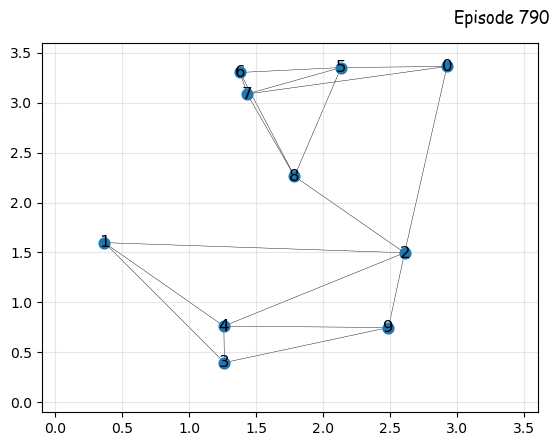

In [7]:
N = 10                      # Number of agents
L = 3.5                     # The length of the simulation box
env = Distributed_System(N,L)

batch_size = 20
discount_rate = 0.98
file, model, n_outputs, replay_memory, best_weights, state, reward = initializer(env, N)

camera = Camera(plt.figure())


best_H   = 0
Hamilton = []            # just for plot total hamilton per episode
giant = []

# just for checking prolems
all_q = []; next_q = []; qq = []; target_q = []; LOSS = [];
for i in range(N): all_q.append(0); next_q.append(0); qq.append(0); target_q.append(0); LOSS.append(0)



# ---------------------------------------------------------------------------------------
for episode in range(800):
    
    for _ in range(20):
        epsilon = max(1 - episode/600, 0.0)               # first is more random and than use greedy
        state, reward = play_one_step(env, N, model, state, n_outputs, replay_memory, epsilon)

    if episode > 50:
        for i in range(N):
            (all_q[i], next_q[i], qq[i], target_q[i], LOSS[i],
             grads, trainable_variables) = training_step(i, model, n_outputs, replay_memory, batch_size, discount_rate)
        log_print(file, N, env, episode, epsilon, reward, 
                  all_q, next_q, qq, target_q, LOSS, grads, trainable_variables)    
    
     
    H = env.Hamiltonian()[0].sum()                      # hamiltonian of the whole system  ###
    Hamilton.append(H) 
    
    if H <= best_H and episode > 500:                   # find the minimum of Hamiltonian
        for i in range(N):
            best_weights[i] = model[i].get_weights()    # saving model weights for the best Hamiltonian
            best_H = H
        
      
    if episode%10 == 0:
        giant.append( env.Plot(camera, episode) )
        
    print("\rEpisode: {}, eps: {:.3f}, Min(Hamilton): {:.3f}, H: {:.3f},     R1: {:.3f}, R2: {:.3f}, R3: {:.3f}, R4: {:.3f}"
          .format(episode, epsilon, best_H, H, env.r[0], env.r[1], env.r[2], env.r[3]), end="")
    
    
anim = camera.animate(interval= 100, repeat=True, repeat_delay= 500, blit=True)
anim.save('./animation/animation_C.gif')
file.close()

-31.51053287849683


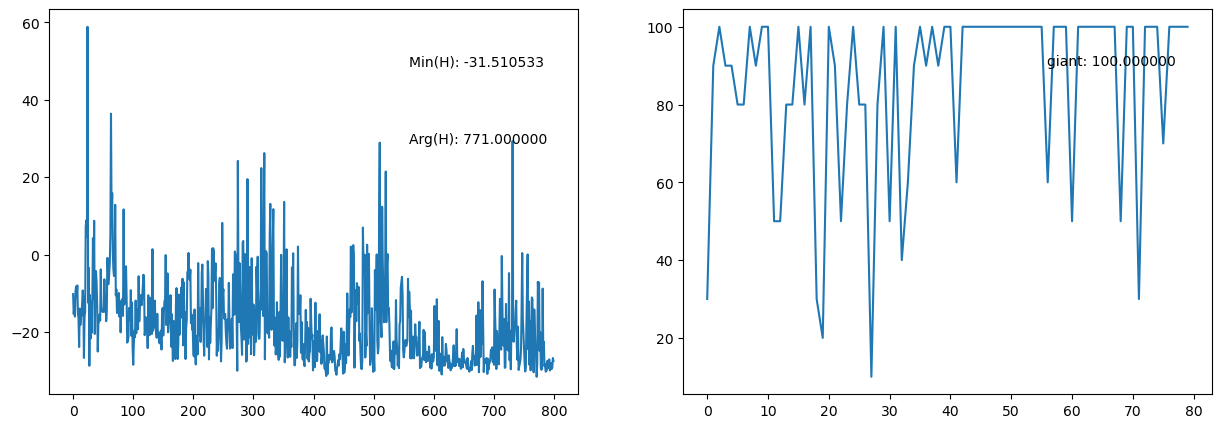

In [8]:
print(best_H)
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Hamilton)
plt.text(0.7*episode, max(Hamilton)-10, "Min(H): %f" % (min(Hamilton)) )
plt.text(0.7*episode, max(Hamilton)-30, "Arg(H): %f" % (np.argmin(Hamilton)) )

plt.subplot(1,2,2)
plt.plot(giant)
plt.text( 0.7*episode/10, max(giant)-10, "giant: %f" % (max(giant)) )
plt.show()

Episode: 799, Min(Hamilton): -31.511, H: -27.071

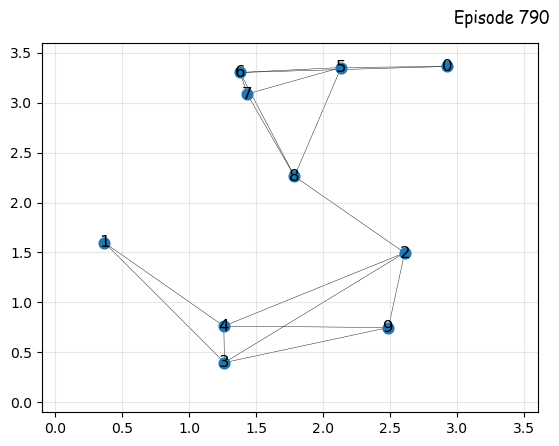

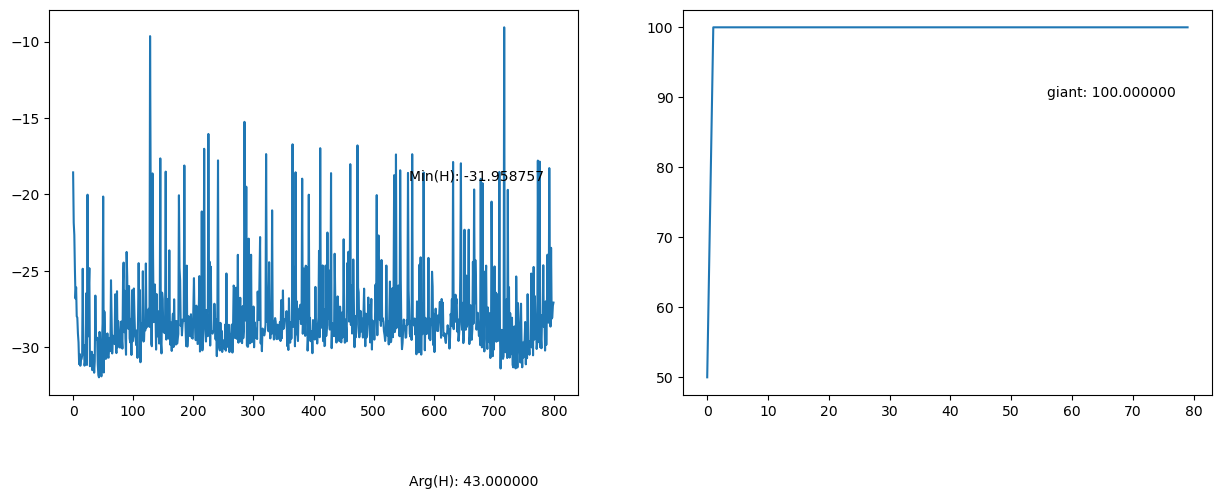

In [15]:
for i in range(N):
    model[i].set_weights(best_weights[0])


env = Distributed_System(N,L)
state, reward = env.step(np.zeros(N),0)
state = [[state[j][i] for j in range(3)] for i in range(N)]
action = np.zeros(N)

camera2 = Camera(plt.figure())
Hamilton = []
g = []

for ii in range(800):
    for i in range(N):
        actionnnn = model[i].predict(np.reshape(state[i], (3)).reshape(1, -1), verbose=0)[0]
        action[i] = np.argmax(actionnnn)
    
    next_state, reward = env.step((action-0.5)*2,0)
    next_state = [[next_state[j][i] for j in range(3)] for i in range(N)]
    state = next_state
      
    H = env.Hamiltonian()[0].sum()       # hamiltonian of the whole system  ###
    Hamilton.append(H) 
    
    if ii%10 == 0:
        g.append( env.Plot(camera2, ii) )

    print("\rEpisode: {}, Min(Hamilton): {:.3f}, H: {:.3f}".format(ii, best_H, H), end="")
        
        
anim = camera2.animate(interval= 100, repeat=True, repeat_delay= 500, blit=True)
anim.save('./animation/animation_C2.gif')


#-------------------------------------------------------------------------------
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(Hamilton)
plt.text(0.7*episode, max(Hamilton)-3, "Min(H): %f" % (min(Hamilton)) )
plt.text(0.7*episode, max(Hamilton)-5, "Arg(H): %f" % (np.argmin(Hamilton)) )

plt.subplot(1,2,2)
plt.plot(g)
plt.text( 0.7*episode/10, max(g)-10, "giant: %f" % (max(g)) )
plt.show()

tests